In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

C:\Users\User\miniconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [4]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

               length
data_et       2700001
data_trial     133206
data_subject      316


# Create datasets

## data_et

In [5]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['trial_duration_exact'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

## data_trial

In [ ]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [ ]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [ ]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Trials with high t_task

In [16]:
data_et_fix.loc[data_et_fix['t_task']>5100, :] \
    .groupby(['run_id'])['x'].count()

run_id
1.0      27
9.0      37
70.0     18
80.0     18
97.0     29
183.0     8
242.0    18
256.0     5
271.0    15
301.0     1
345.0    21
357.0     6
444.0     1
Name: x, dtype: int64

In [17]:
data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5100, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]

,run_id,trial_index,trial_duration_exact
0,1,106.0,6337.0
1,1,109.0,6371.0
2,1,112.0,6296.0
3,1,115.0,6318.0
4,1,118.0,6310.0
...,...,...,...
226,444,131.0,5507.0
227,444,135.0,5580.0
228,444,498.0,8169.0
229,444,506.0,5543.0


## Missing values - Glasses

In [14]:
subjects_NA_glasses = data_subject.loc[
    pd.isna(data_subject['glasses_binary']),
    'run_id'
]

print(f'{len(subjects_NA_glasses)} were excluded because we did not know anything about their sight')
subjects_NA_glasses

KeyError: 'glasses_binary'

# Cleaning

In [13]:
excludedSubjects = list(subjects_NA_glasses)
excludedSubjects

output = pd.DataFrame(
   {'name': [
               'subjects_NA_glasses'
   ],
    'length': [
                len(subjects_NA_glasses)
           ]}
)

print(f'{len(subjects_NA_glasses)} were excluded because we did not know anything about their sight')

output

NameError: name 'subjects_noInstruction' is not defined

In [ ]:
def generalCleaning(data) {
    print(f'Raw: {len(data)}')
    data = data.loc[
        ~data['run_id'].isin(excludedSubjects),
        :
    ]
    print(f'Cleaned: {len(data)}')
    return(data)
}

data_trial = generalCleaning(data_trial)

In [ ]:
def remove_high_tTask(data):
    return = data.loc[data['trial_duration_exact']<5100, :]

data_trial = remove_high_tTask(data_trial)
data_et = remove_high_tTask(data_et)
data_trial_fix = remove_high_tTask(data_trial_fix)
data_et_fix = remove_high_tTask(data_et_fix)

# Offset

## Calculate on gaze point-level

In [25]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [26]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et['offset_px'].describe()

count    2.020561e+06
mean     2.202884e+02
std      3.480406e+02
min      1.064561e-01
25%      7.777781e+01
50%      1.464224e+02
75%      2.790172e+02
max      1.127067e+05
Name: offset_px, dtype: float64

In [27]:
print(data_et[['offset', 'offset_px']].describe())
print(data_et_fix[['offset', 'offset_px']].describe())

             offset     offset_px
count  2.020561e+06  2.020561e+06
mean   1.813469e-01  2.202884e+02
std    3.273277e-01  3.480406e+02
min    1.169144e-04  1.064561e-01
25%    6.674734e-02  7.777781e+01
50%    1.266268e-01  1.464224e+02
75%    2.381955e-01  2.790172e+02
max    1.302936e+02  1.127067e+05
              offset      offset_px
count  234459.000000  234459.000000
mean        0.170972     205.105594
std         0.150083     193.549082
min         0.000452       0.531538
25%         0.075663      88.847104
50%         0.129372     151.278882
75%         0.218084     254.952246
max         3.491787    6628.081209


In [28]:
data_et_fix.columns

Index(['x', 'y', 't', 't_task', 'run_id', 'trial_index', 'task_nr', 'chin',
       'chinFirst', 'trial_type', 'trial_duration', 'trial_duration_exact',
       'x_pos', 'y_pos', 'window_width', 'window_height', 'offset',
       'offset_px'],
      dtype='object')

In [29]:
data_et_fix.loc[data_et_fix['offset']>1, ['x_pos', 'y_pos', 'x', 'y', 'offset']]

,x_pos,y_pos,x,y,offset
2622,0.2,0.8,0.699318,-0.602470,1.488705
2623,0.2,0.8,0.714940,-0.601017,1.492653
2624,0.2,0.8,0.742320,-0.630964,1.530284
2625,0.2,0.8,0.732112,-0.622791,1.519038
2626,0.2,0.8,0.744161,-0.615793,1.516767
...,...,...,...,...,...
232497,0.8,0.8,-0.128750,-0.080300,1.279650
232498,0.8,0.8,-0.145051,-0.099996,1.305034
232499,0.8,0.8,-0.121925,-0.084423,1.277556
232500,0.8,0.8,-0.106289,-0.075723,1.260258


## Plot: gaze shift within a trial

In [30]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [31]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [32]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

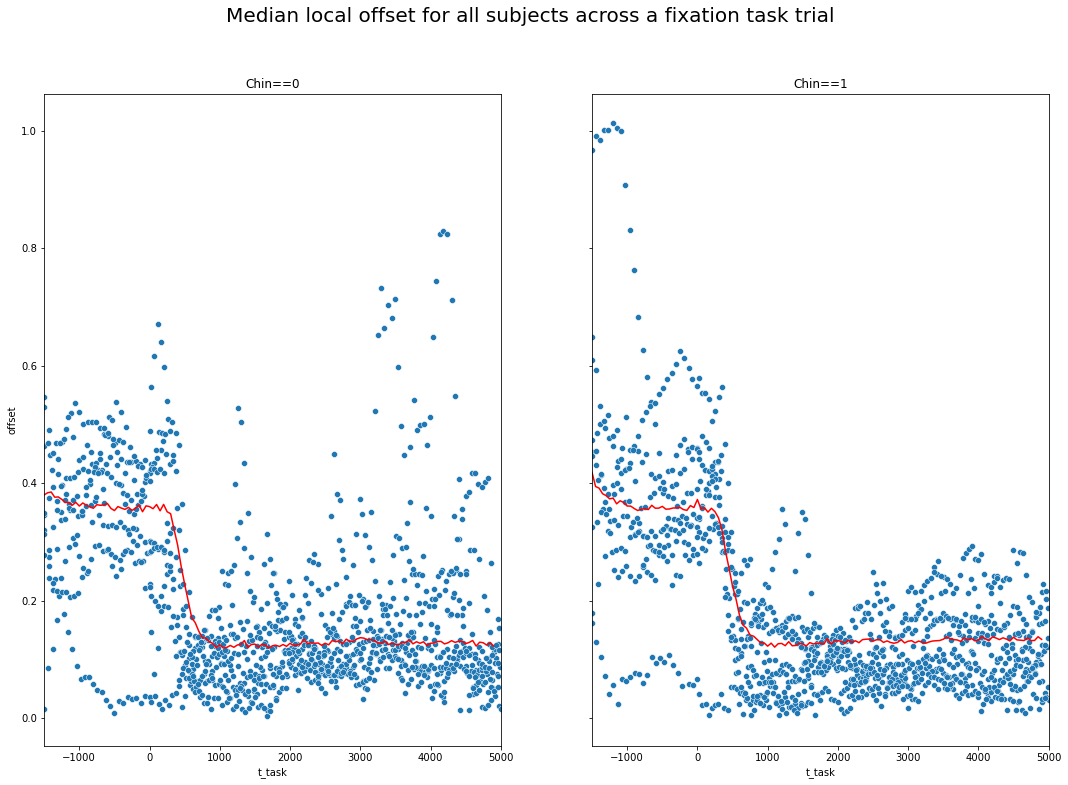

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [34]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')
data_trial_fix['offset']

0       0.126908
1       0.201564
2       0.163404
3       0.117219
4       0.166590
          ...   
4413         NaN
4414         NaN
4415         NaN
4416         NaN
4417         NaN
Name: offset, Length: 4418, dtype: float64

In [35]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')


## Fixation task trial index

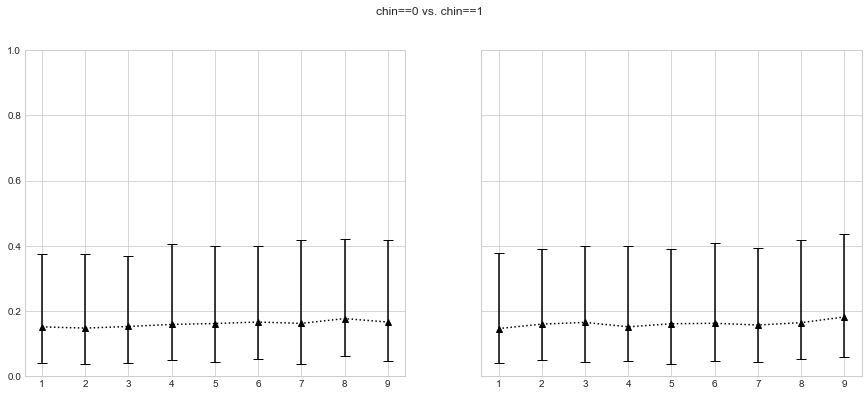

In [36]:
def group_chin_withinTaskIndex(data, varName):
    df_m = data.groupby(['chin', 'withinTaskIndex']) \
        [varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_median'}) \
        .reset_index()

    data = data.merge(df_m, on=['chin', 'withinTaskIndex'], how='left')
    data['above_median'] = data[varName] > data[varName + '_median']
    
    df_std_upper = data.loc[data['above_median']==1, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_upper'}) \
        .reset_index()
    df_std_lower = data.loc[data['above_median']==0, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_lower'}) \
        .reset_index()

    output = pd.concat([
        df_m, 
        df_std_upper[varName + '_std_upper'],
        df_std_lower[varName + '_std_lower']
    ], axis=1)
    return output


data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'offset'
)

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['offset_median'],
        yerr=[data['offset_std_lower'], data['offset_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Fixation positions

In [37]:
data_trial_fix.groupby(['x_pos', 'y_pos']) \
    ['offset'].median() \
    .reset_index()

,x_pos,y_pos,offset
0,0.2,0.2,0.157789
1,0.2,0.5,0.132668
2,0.2,0.8,0.164143
3,0.5,0.2,0.148441
4,0.5,0.5,0.107403
5,0.5,0.8,0.116816
6,0.8,0.2,0.149674
7,0.8,0.5,0.117100
8,0.8,0.8,0.148703


## Aggregate on subject-level 

In [38]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [39]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,0.178822,0.174820,0.181917,0.177706,0.173351
std,0.112666,0.120503,0.129599,0.121111,0.074989
min,0.053580,0.045764,0.053778,0.053580,0.063450
25%,0.110497,0.106458,0.106316,0.104167,0.116900
50%,0.146943,0.140937,0.144487,0.141081,0.160397
75%,0.212820,0.201206,0.204863,0.206994,0.211397
max,0.826387,1.018857,1.054631,0.803838,0.456543


In [40]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,214.597611,206.991095,221.306696,209.564288,210.273488
std,159.906466,153.736527,197.306902,157.642495,115.908527
min,63.404467,53.524854,58.066425,63.404467,63.620122
25%,125.154054,118.683952,123.017406,116.591567,131.883146
50%,169.616320,159.696931,167.551892,154.416383,190.032698
75%,240.876316,233.787859,251.440214,233.801925,242.147189
max,1343.748306,1111.197358,1814.364642,1073.632845,851.448521


## Grand mean offset

In [41]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-41-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,4297.000000,4297.000000,4297.000000,4297.000000
mean,0.513063,798.337275,0.511705,458.767362
std,0.230196,403.464952,0.213496,212.790759
min,-0.235286,-376.458066,-0.367823,-331.041102
25%,0.317361,499.074229,0.350188,305.879644
50%,0.513279,760.103464,0.520517,450.594075
75%,0.706236,1056.524741,0.671976,591.000000
max,3.633613,6976.536940,2.171791,2280.380605


In [42]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    4297.000000
mean        0.166403
std         0.159715
min         0.000995
25%         0.070429
50%         0.123955
75%         0.211245
max         3.491787
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [43]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-43-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,234459.000000,2.344590e+05
mean,0.007125,9.553182e+03
std,0.025493,3.061681e+04
min,0.000000,0.000000e+00
25%,0.000799,9.874107e+02
50%,0.002401,3.053804e+03
75%,0.006295,8.226625e+03
max,3.006582,1.784821e+06


## Aggregate standard deviation on trial-level

In [44]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    4297.000000
mean        0.071214
std         0.044511
min         0.000000
25%         0.046248
50%         0.062225
75%         0.086095
max         0.714282
Name: precision, dtype: float64


In pixel

In [45]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    4297.000000
mean       82.206735
std        53.090651
min         0.000000
25%        52.094711
50%        71.092870
75%        98.065890
max       876.150962
Name: precision_px, dtype: float64


Any missing values?

In [46]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision
2583,355,107.0,0.5,0.2,NaN
2584,355,111.0,0.5,0.8,NaN
2585,355,115.0,0.2,0.2,NaN
2586,355,119.0,0.2,0.5,NaN
2587,355,123.0,0.2,0.8,NaN
...,...,...,...,...,...
4413,98,243.0,0.8,0.2,NaN
4414,98,246.0,0.2,0.8,NaN
4415,98,249.0,0.2,0.5,NaN
4416,98,252.0,0.5,0.5,NaN


## Precision across trials

In [47]:
data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'precision'
)
data_plot

,index,chin,withinTaskIndex,precision_median,precision_std_upper,precision_std_lower
0,0,0.0,1.0,0.107214,0.134250,0.083515
1,1,0.0,2.0,0.102818,0.140369,0.082711
2,2,0.0,3.0,0.107058,0.134545,0.084097
3,3,0.0,4.0,0.108064,0.130572,0.087232
4,4,0.0,5.0,0.107293,0.131768,0.082170
5,5,0.0,6.0,0.105349,0.130672,0.083393
6,6,0.0,7.0,0.107486,0.139473,0.080979
7,7,0.0,8.0,0.107756,0.131722,0.083391
8,8,0.0,9.0,0.106537,0.135113,0.083924
9,9,1.0,1.0,0.110734,0.140445,0.080993


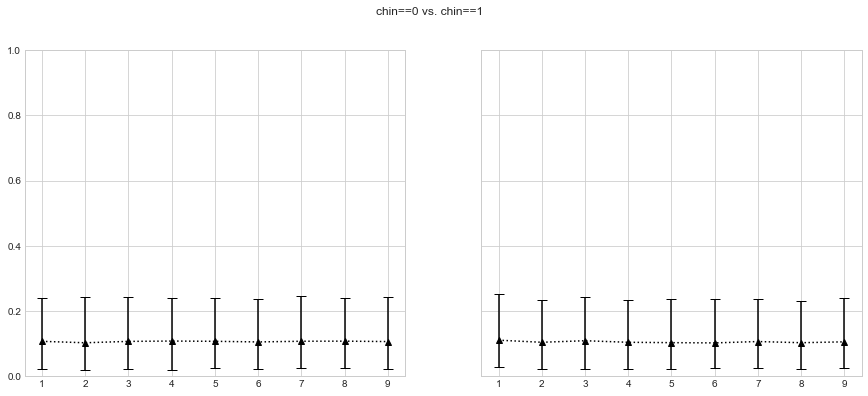

In [48]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['precision_median'],
        yerr=[data['precision_std_lower'], data['precision_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Aggregate on subject-level 

In [49]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,0.071651,0.072566,0.070820,0.069917,0.074550
std,0.028969,0.030296,0.036051,0.031569,0.023717
min,0.000000,0.000000,0.000000,0.000002,0.000002
25%,0.055574,0.056728,0.053084,0.054423,0.061697
50%,0.067120,0.069096,0.064887,0.064402,0.070567
75%,0.083966,0.082575,0.080607,0.082785,0.085315
max,0.270525,0.284938,0.408137,0.270525,0.175707


In pixel

In [50]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,82.466421,83.662536,81.427473,80.694133,85.578112
std,34.583827,37.664830,39.979597,36.677147,30.536173
min,0.000000,0.000000,0.000000,0.002056,0.002383
25%,61.625630,61.694975,57.019687,60.672100,67.617130
50%,77.641353,76.795413,77.384107,72.829141,81.152388
75%,96.066845,96.441993,95.591210,94.334942,98.079125
max,256.587017,306.417389,391.176827,256.587017,202.306597


# chinFirst: Randomization worked? 

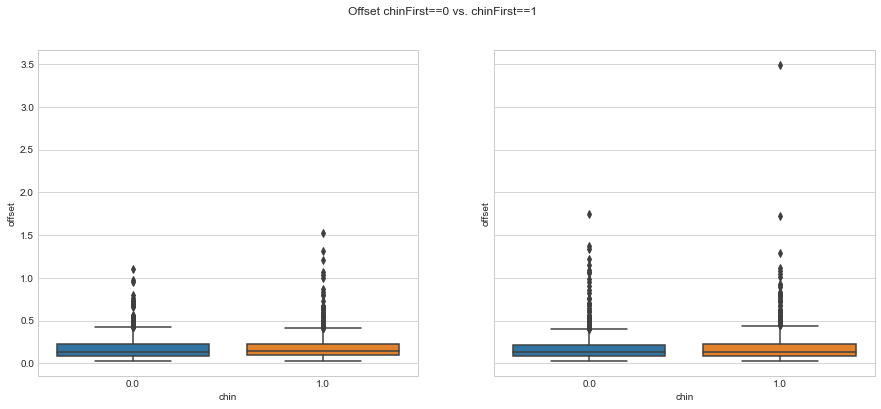

In [51]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

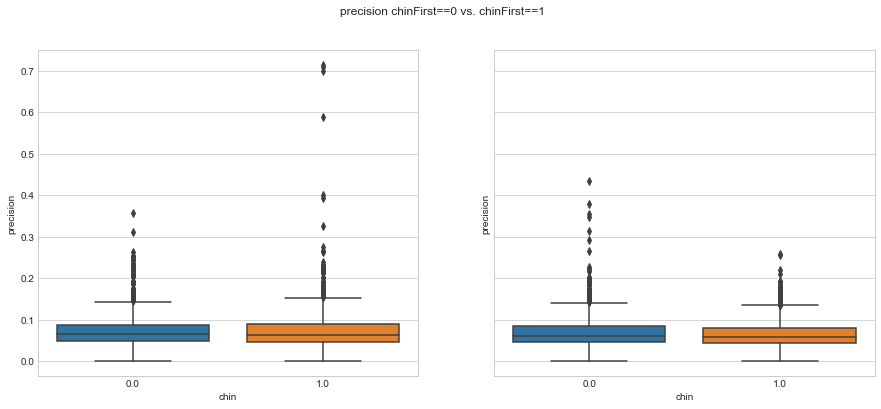

In [52]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

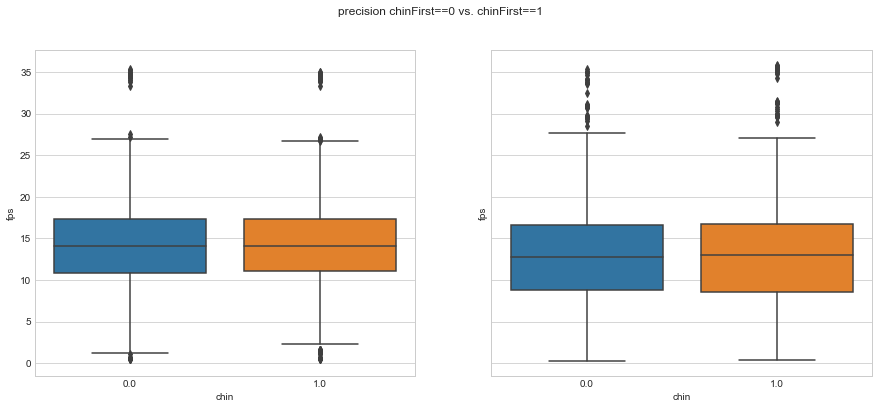

In [53]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Main effect: chin-rest
 - t-tests will follow
 - TODO: Compare subjects with high fps (Semmelmann & Weigelt, 2019)

In [54]:
data_trial_fix['fps'].median()
data_trial_fix['high_fps']=0
data_trial_fix.loc[
    data_trial_fix['fps']>data_trial_fix['fps'].median(),
    'high_fps'
]=1

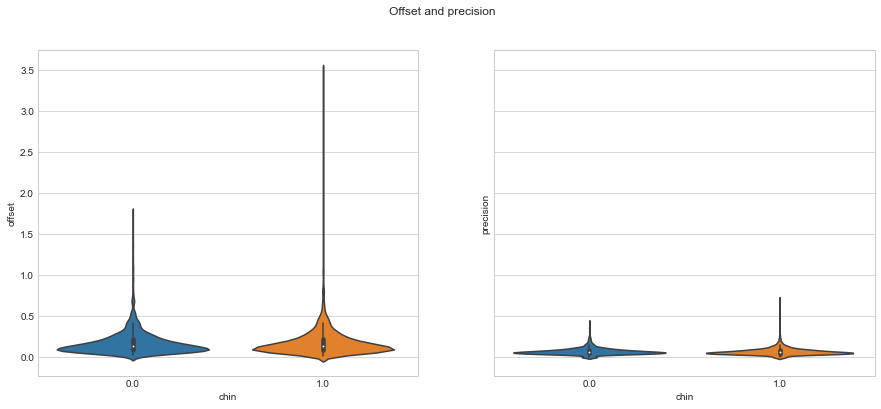

In [55]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               data=data_trial_fix)
   
plt.show()

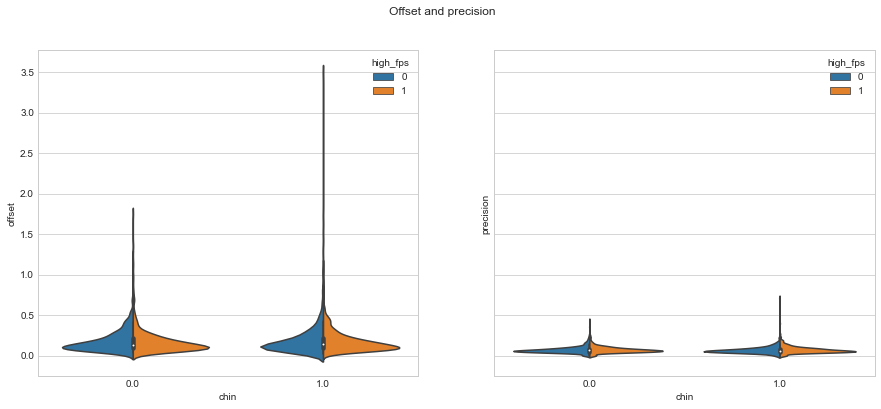

In [56]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
   
plt.show()

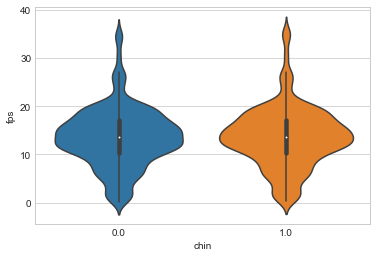

In [57]:
sns.violinplot(x='chin', y='fps', data=data_trial_fix)   
plt.show()

In [58]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.174820,0.014521
1,offset_chin_1,0.181917,0.016796
2,precision_chin_0,0.072566,0.000918
3,precision_chin_1,0.070820,0.001300


In [59]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-1.0203348446416043, pvalue=0.3086703995888802)

## offset across fixation positions

In [60]:
data_trial_fix.groupby(['chin', 'x_pos', 'y_pos']) \
    ['offset'].mean() \
    .reset_index()

# rej, pval_corr = smm.multipletests(pval_raw, alpha=alpha, method='h')[:2]

,chin,x_pos,y_pos,offset
0,0.0,0.2,0.2,0.194143
1,0.0,0.2,0.5,0.161602
2,0.0,0.2,0.8,0.199945
3,0.0,0.5,0.2,0.188816
4,0.0,0.5,0.5,0.135570
5,0.0,0.5,0.8,0.155475
6,0.0,0.8,0.2,0.200885
7,0.0,0.8,0.5,0.162008
8,0.0,0.8,0.8,0.190866
9,1.0,0.2,0.2,0.192865


## Offset & precision across fixation dot positions

In [61]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.176590
offset_chin_1           0.183153
offset_var_chin_0       0.020361
offset_var_chin_1       0.027673
precision_chin_0        0.072164
precision_chin_1        0.070269
precision_var_chin_0    0.001676
precision_var_chin_1    0.002221
dtype: float64


<ipython-input-61-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-61-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.194143,0.192865,0.019925,0.019606,0.080712,0.079655,0.001771,0.002076
1,1,0.188816,0.185007,0.020964,0.016681,0.075108,0.073524,0.001784,0.003045
2,2,0.200885,0.194654,0.032662,0.023687,0.083947,0.078608,0.002231,0.003104
3,3,0.161602,0.177254,0.011622,0.062077,0.072392,0.067396,0.001701,0.001552
4,4,0.135570,0.139182,0.010343,0.011103,0.063367,0.060781,0.001860,0.001139
5,5,0.162008,0.165316,0.022058,0.021022,0.072395,0.065962,0.001820,0.001006
6,6,0.199945,0.212267,0.023398,0.027033,0.070754,0.071096,0.001196,0.003491
7,7,0.155475,0.177734,0.017538,0.035097,0.063301,0.065569,0.001252,0.002582
8,8,0.190866,0.204098,0.024737,0.032753,0.067497,0.069830,0.001467,0.001993


# Visual aid & chin rest

In [62]:
data_trial_fix.columns

Index(['run_id', 'subject', 'prolificID', 'chinFirst', 'trial_index',
       'task_nr', 'rt', 'stimulus', 'key_press', 'time_elapsed', 'recorded_at',
       'window_width', 'window_height', 'success', 'chin', 'x_pos', 'y_pos',
       'window_width_max', 'window_height_max', 'window_diagonal_max',
       'window_diagonal', 't_startTrial', 'trial_duration_exact', 'fixTask',
       'withinTaskIndex', 'x_count', 'fps', 'positionIndex', 'glasses_binary',
       'offset', 'offset_px', 'x_mean', 'y_mean', 'x_mean_px', 'y_mean_px',
       'grand_deviation', 'distanceFromAVG_square', 'precision',
       'distanceFromAVG_square_px', 'precision_px', 'high_fps'],
      dtype='object')

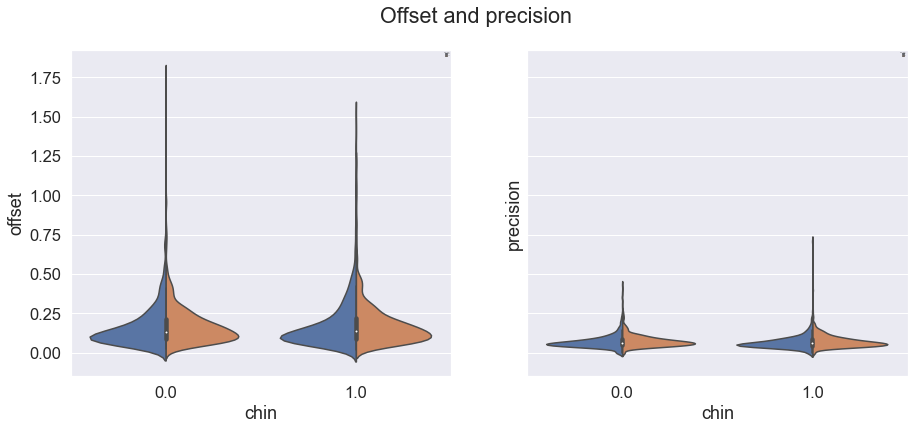

In [92]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.set(font_scale=0)
sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               hue='glasses_binary',
               split=True,
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               hue='glasses_binary',
               split=True,
               data=data_trial_fix)
   
plt.show()

# Main effect: Visual Aid

## Frequency of visual aids

In [64]:
for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight        23
noCorrection    106
progressive      18
shortSight       83


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101


col_0           count
glasses_binary       
0.0               137
1.0                93




## offset & precision on subject-level

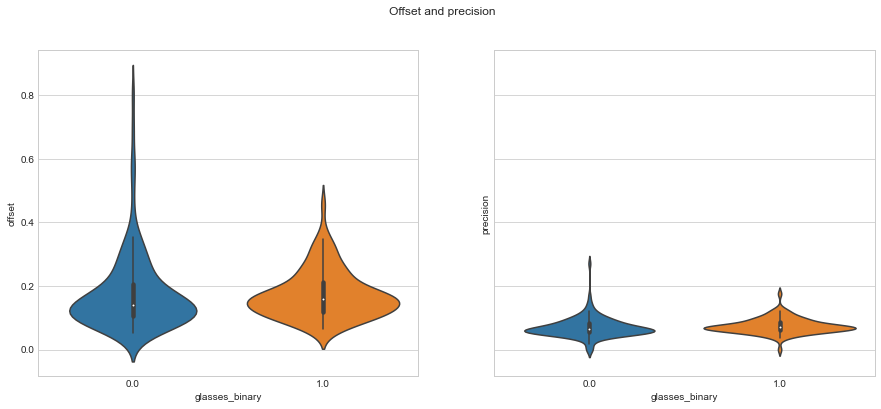

In [65]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='glasses_binary', 
               y='offset', 
               data=data_subject)
sns.violinplot(ax=axes[1], 
               x='glasses_binary', 
               y='precision', 
               data=data_subject)
   
plt.show()

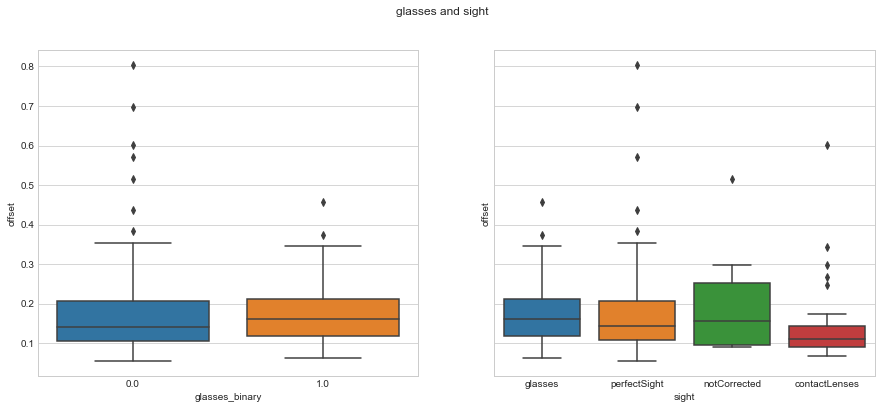

In [66]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

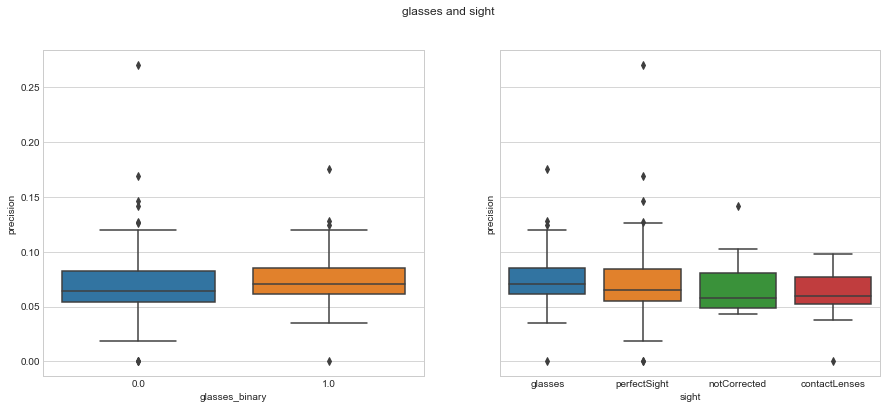

In [67]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='precision', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='precision', data=data_subject)
   
plt.show()

# Gaze predictions

## Gaze dot positions for each position

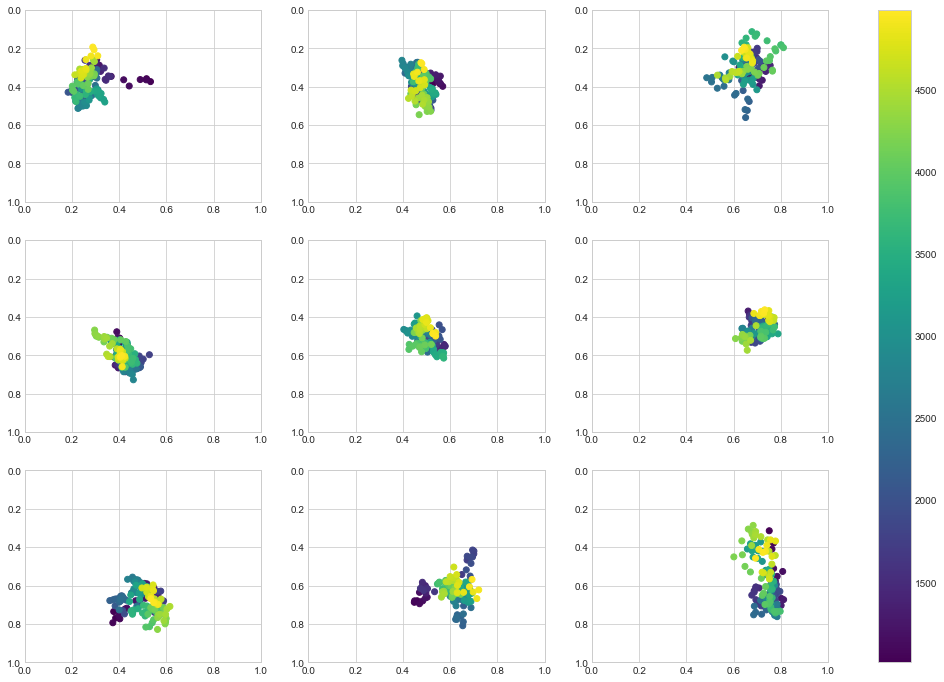

In [68]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

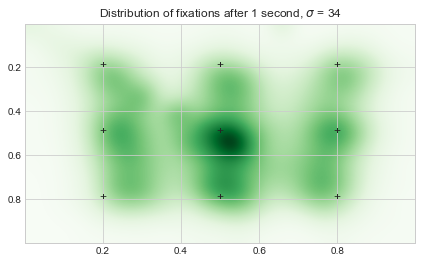

<Figure size 432x288 with 0 Axes>

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Additional analyis

## Median offset across calibration trials
Does data quality improve during calibration? 

In [70]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial \
    .loc[data_trial['trial_type']=='eyetracking-calibration', :]

# Add median offset 
grouped = data_et_calibration \
    .groupby(['run_id', 'trial_index'])['offset'].median() \
    .reset_index() \
    .rename(columns={'offset': 'offset_median'}) 
data_trial_calibration = data_trial_calibration.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


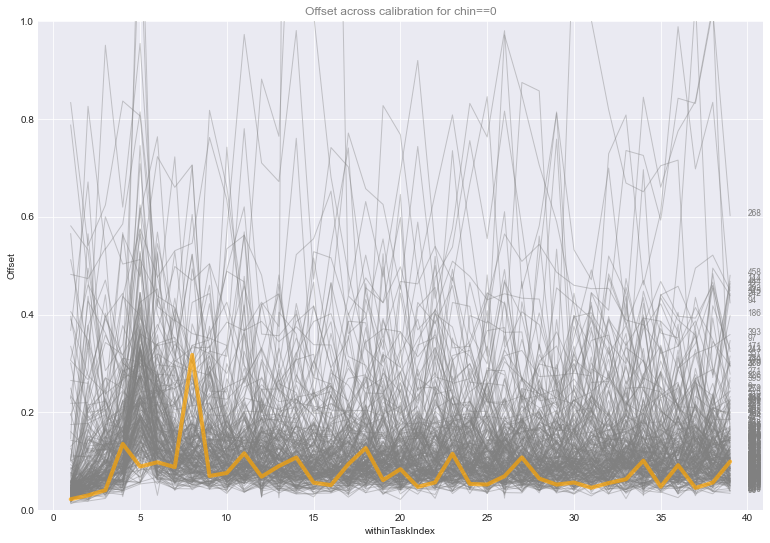

In [71]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


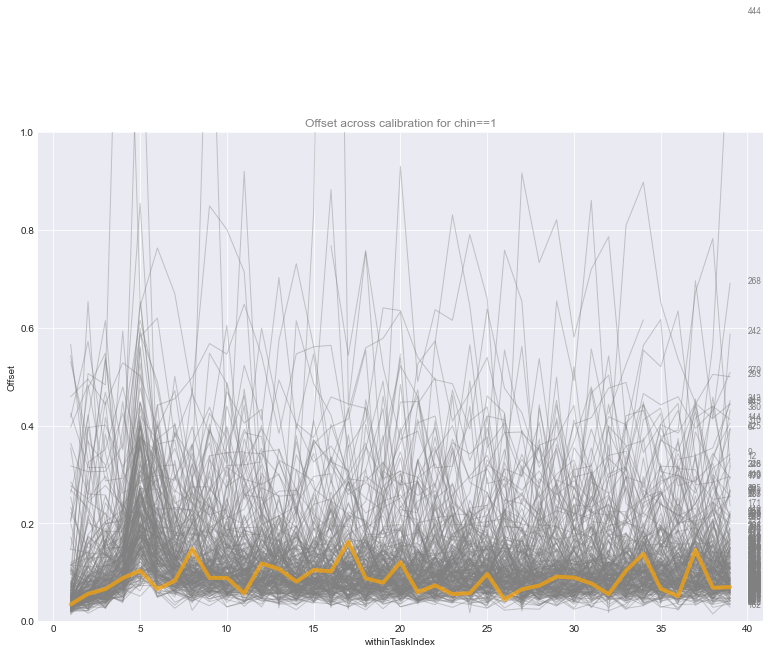

In [72]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Median precision across calibration trials

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


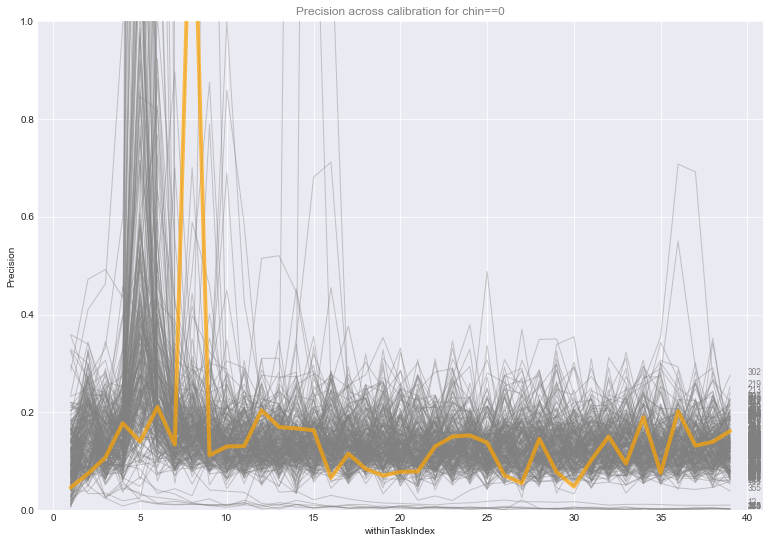

In [73]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


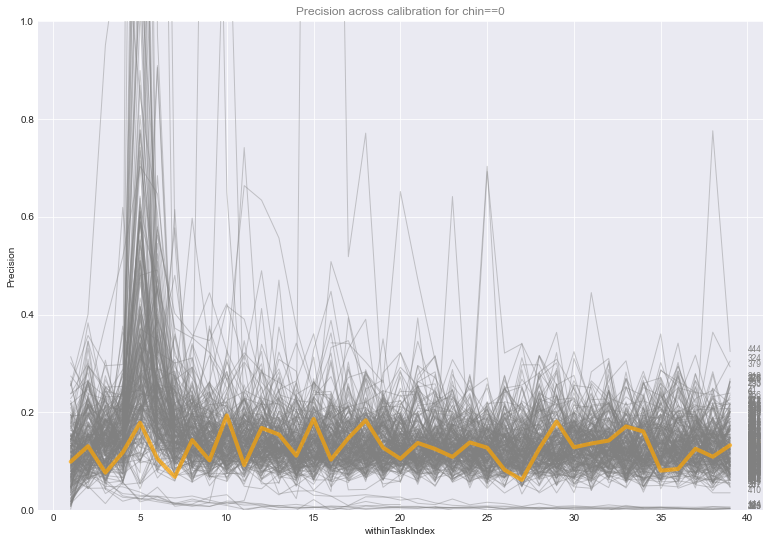

In [74]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## Categorical confounders

In [75]:
predictors = [
    'vertPosition', 'gender', 'ethnic',  
    'degree', 'browser', 'glasses', 'sight', 'sight']  
for col in predictors:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
vertPosition       
a                91
b               109
c                30


col_0    count
gender        
diverse      4
female     106
male       120


col_0      count
ethnic          
asian         45
black         17
caucasian    149
hispanic      19


col_0    count
degree        
college    117
grad        40
high        63
middle       2


col_0    count
browser       
Chrome     215
Edge        17
Firefox     30
Opera        4
Safari      10


col_0         count
glasses            
longSight        23
noCorrection    106
progressive      18
shortSight       83


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101




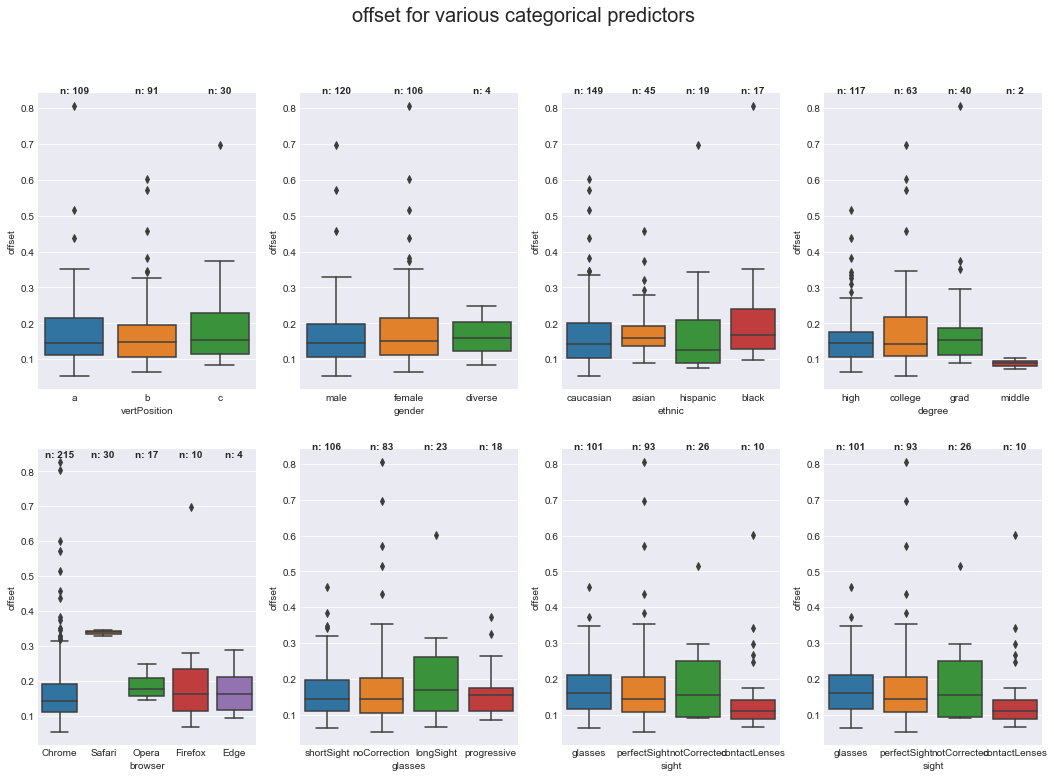

In [76]:
def getBoxPlots(outcome, yPos):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))
    fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
    ax = ax.ravel()
    for i in range(0, 8):
        sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)
        nobs = data_subject[predictors[i]].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax[i].get_xticklabels()):
            ax[i].text(pos[tick], yPos, nobs[tick], # medians[tick] + 0.02
            verticalalignment='top',
            horizontalalignment='center', size='medium', weight='semibold')
            
getBoxPlots('offset', 0.86)

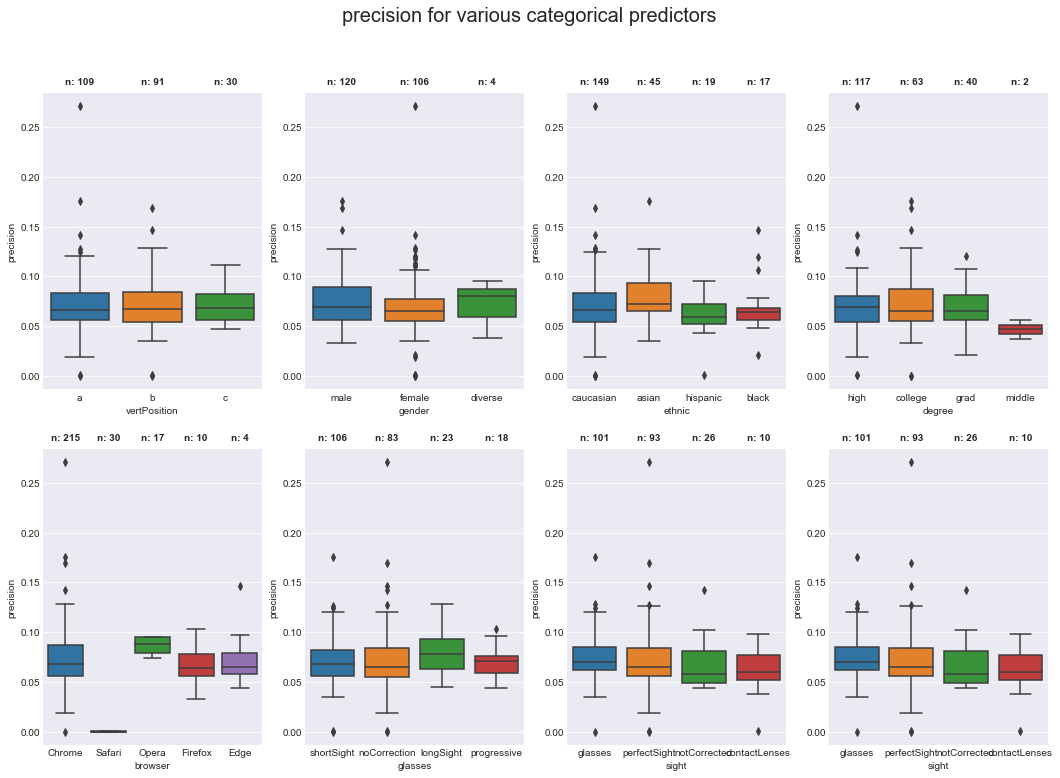

In [77]:
getBoxPlots('precision', yPos=0.30)

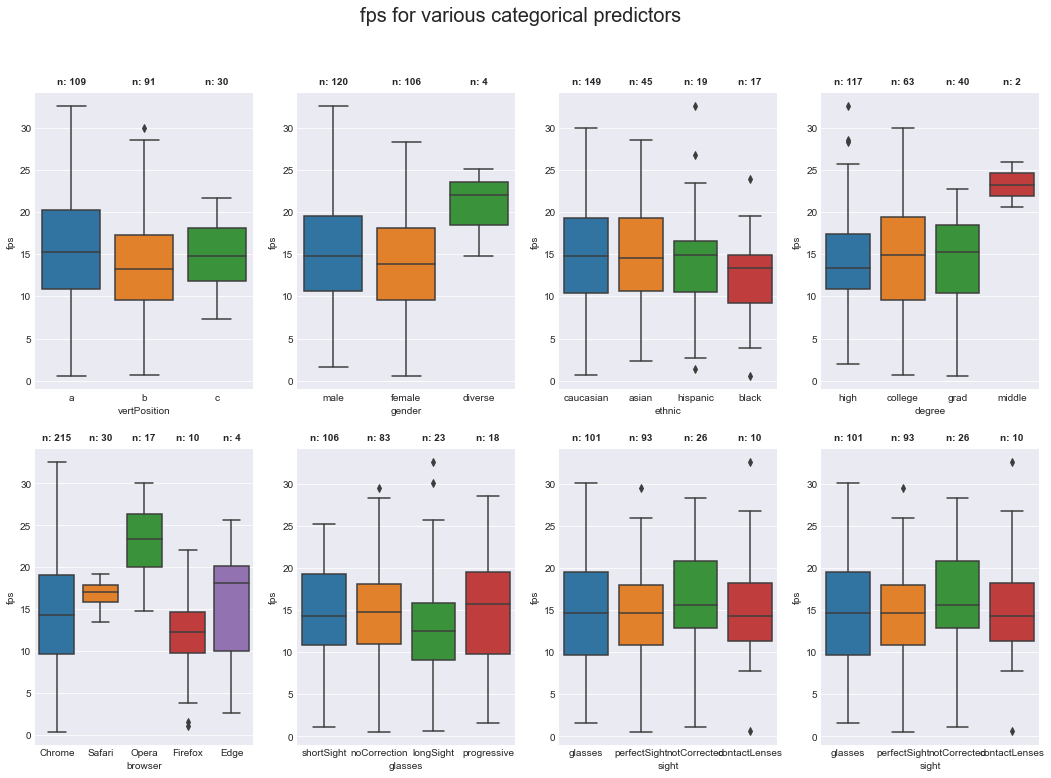

In [78]:
getBoxPlots('fps', yPos=36)

## Correlation Plot

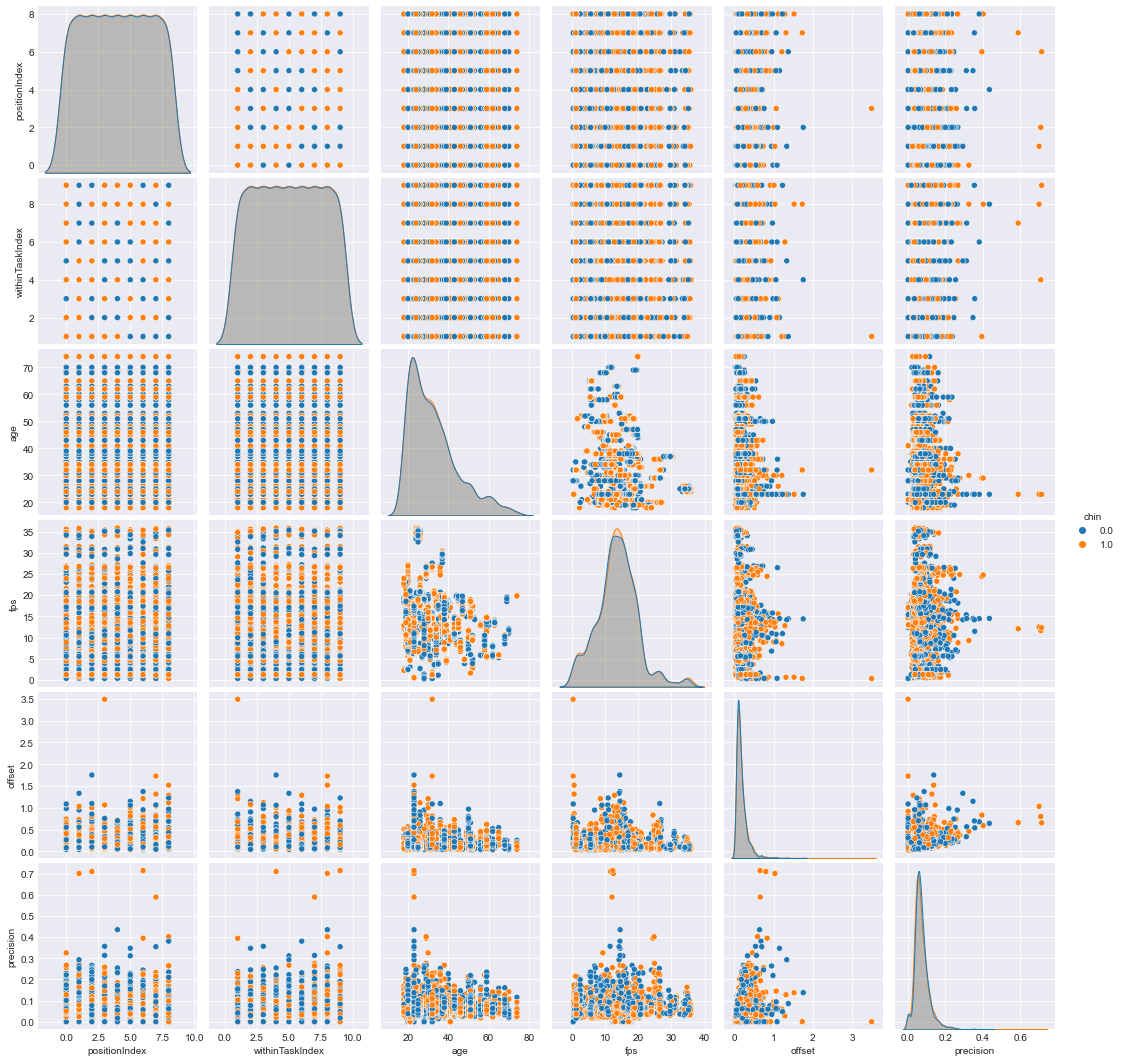

In [79]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

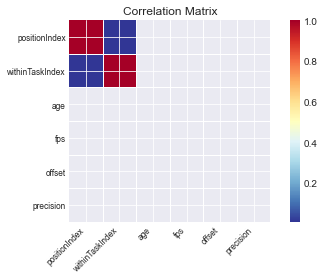

In [80]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [81]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,***
withinTaskIndex,0.009,-,,,,**
age,0.0,0.0,-,***,,
fps,0.0,0.004,-0.144,-,***,*
offset,-0.009,0.025,-0.021,-0.124,-,***
precision,-0.094,0.048,-0.001,0.03,0.243,-


In [82]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,4418,4094,4299,4297,4297
withinTaskIndex,0.009,-,4094,4299,4297,4297
age,0.0,0.0,-,3975,3973,3973
fps,0.0,0.004,-0.144,-,4297,4297
offset,-0.009,0.025,-0.021,-0.124,-,4297
precision,-0.094,0.048,-0.001,0.03,0.243,-


# MLA Model

In [83]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: precision
No. Observations: 4297    Method:             REML     
No. Groups:       240     Scale:              0.0012   
Min. group size:  5       Log-Likelihood:     8041.6054
Max. group size:  18      Converged:          Yes      
Mean group size:  17.9                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.072    0.002 32.920 0.000  0.067  0.076
x_pos        -0.001    0.002 -0.500 0.617 -0.005  0.003
Group Var     0.001    0.002                           



C:\Users\User\miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Export

In [84]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [85]:
print('Success! Script ran through')

Success! Script ran through
